# Orientation Analysis

In [1]:
import gsd
import gsd.hoomd
import numpy
from matplotlib import pyplot

In [2]:
# To show orientations, we use arrows rotated by the quaternions.
from mpl_toolkits.mplot3d.axes3d import Axes3D

# These functions are adapted from the rowan quaternion library.
# See rowan.readthedocs.io for more information.
def quat_multiply(qi, qj):
    """Multiply two sets of quaternions."""
    output = numpy.empty(numpy.broadcast(qi, qj).shape)

    output[..., 0] = qi[..., 0] * qj[..., 0] - \
        numpy.sum(qi[..., 1:] * qj[..., 1:], axis=-1)
    output[..., 1:] = (qi[..., 0, numpy.newaxis] * qj[..., 1:] +
                       qj[..., 0, numpy.newaxis] * qi[..., 1:] +
                       numpy.cross(qi[..., 1:], qj[..., 1:]))
    return output

def quat_rotate(q, v):
    """Rotate a vector by a quaternion."""
    v = numpy.array([0, *v])
    
    q_conj = q.copy()
    q_conj[..., 1:] *= -1
    
    return quat_multiply(q, quat_multiply(v, q_conj))[..., 1:]

In [3]:
def orientationPlot(step, t):
    L = t[0].particles.N
    positions = t[step].particles.position[0:L];
    
    orientations = t[step].particles.orientation[0:L]
    arrowheads = quat_rotate(orientations, numpy.array([1, 0, 0]))

    fig = pyplot.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver3D(positions[:, 0], positions[:, 1], positions[:, 2],
                arrowheads[:, 0], arrowheads[:, 1], arrowheads[:, 2])
    ax.set_title("Orientations", fontsize=16);

In [4]:
def nematization(step, t):
        Q = nematicOrderTensor(step,t)
        
        eigen_values, eigen_vectors = numpy.linalg.eig(Q)
        idx = eigen_values.argsort()[::-1]   
        
        eigen_values = eigen_values[idx]
       
        return(1.5*eigen_values[0])

In [5]:
def nematicOrderTensor(step, t):
 
    L = t[0].particles.N
    quaternions = t[step].particles.orientation[0:L]
    arrowheads = quat_rotate(quaternions, numpy.array([1, 0, 0]))
    
    
    results = []
    for i in range(5):
        results.append( numpy.outer(arrowheads[i],arrowheads[i])  )
        
    Q = numpy.mean(results, axis=0)  # calculate mean without flattening array
    Q -= numpy.identity(3)/3.0       # subtract Identity/3
    
    return(Q)

In [6]:
def sList(t):

    s = []
    for i in range(len(t)):
        s.append(nematization(i,t))
        
    return(s)

In [7]:
t1 = gsd.hoomd.open("restarted_trayectory_T_8.0.gsd", 'rb')

(0, 1.1)

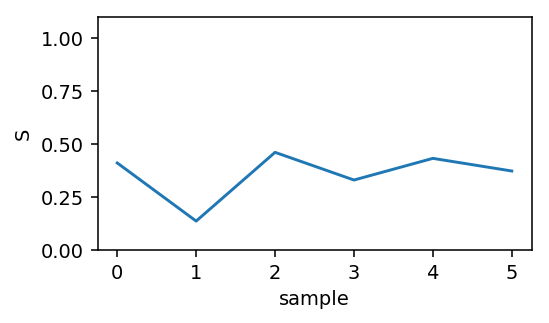

In [8]:
pyplot.figure(figsize=(4,2.2), dpi=140);

s1= sList(t1)

pyplot.plot(
    numpy.arange(len(s1)), 
    s1);

pyplot.xlabel('sample');
pyplot.ylabel('S');
pyplot.ylim((0,1.1))

In [9]:
mean_s = numpy.mean(s1)

In [10]:
std_s = numpy.std(s1)

In [11]:
print(mean_s,std_s)

0.3562825560251322 0.10747135930377885
